# LightGBM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv("hitters.csv")
df = df.dropna()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
dms = pd.get_dummies(df[["League","Division","NewLeague"]])
dms.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [4]:
y = df["Salary"]
X = df.drop(["League","Division","NewLeague","Salary"], axis=1).astype("float64")
X = pd.concat([X, dms[["League_N","Division_W","NewLeague_N"]]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
model = LGBMRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

363.8712087611089

In [6]:
params = {
    "learning_rate": [0.01,0.1,0.5,1],
    "n_estimators": [20,40,100,200,500,1000],
    "max_depth": [1,2,3,4,5,6,7,8,9,10],
}
lgb = LGBMRegressor()
model_cv = GridSearchCV(lgb, params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2377 out of 2400 | elapsed:   22.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   22.5s finished


In [7]:
model_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20}

In [8]:
model_tuned = LGBMRegressor(learning_rate=0.1, max_depth=6, n_estimators=20).fit(X_train, y_train)
y_pred = model_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

371.5044868943621

In [9]:
r2_score(y_test, y_pred)

0.3624434910123553

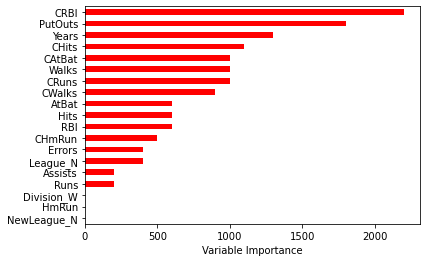

In [11]:
Importance = pd.DataFrame({"Importance": model_tuned.feature_importances_*100}, index=X_train.columns)
Importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="r")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None